In [1]:
import torch
from torch import nn, utils
from torch.nn.functional import relu, sigmoid, binary_cross_entropy
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import wget

In [2]:
if not os.path.exists('vae-cvae-challenge.npz'):
    url = 'https://git.imp.fu-berlin.de/yuxuac94/'\
          'deep-learning-examples/-/raw/master/'\
          '02-Intermediate/vae-cvae-challenge.npz'
    wget.download(url, './vae-cvae-challenge.npz')

# load data
with np.load('vae-cvae-challenge.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# transform into torch tensor
data_x, data_y = map(torch.tensor, (data_x, data_y))

(20000, 784) float32
(20000,) int64


In [3]:
# hyper-parameters
input_size = 784
hidden_size = 256
latent_size = 2
num_classes = 10
num_epochs = 20
batch_size = 50
learning_rate = 0.002
weight_decay = 0

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# create dataset and build dataloader
dataset = utils.data.TensorDataset(data_x,data_y)
data_loader = utils.data.DataLoader(dataset=dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    pin_memory=True)

In [5]:
# build our VAE model
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        # encoder part
        self.hidden_encoder = nn.Linear(input_size, hidden_size)
        self.mu_encoder = nn.Linear(hidden_size, latent_size)
        self.var_encoder = nn.Linear(hidden_size, latent_size)

        # decoder part
        self.latent_decoder = nn.Linear(latent_size, hidden_size)
        self.hidden_decoder = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        hidden = relu(self.hidden_encoder(x))
        mu = self.mu_encoder(hidden)
        log_var = self.var_encoder(hidden)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn(self.latent_size).to(device)
        z = mu + eps * std
        return z

    def decode(self, z):
        hidden = relu(self.latent_decoder(z))
        reconstruct = sigmoid(self.hidden_decoder(hidden))
        return reconstruct
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var, z

In [6]:
# build our CVAE model
class CVAE(nn.Module):
    def __init__(self, input_size, latent_size, num_classes):
        super(CVAE, self).__init__()
        self.latent_size = latent_size
        self.num_classes = num_classes

        # encoder part
        self.hidden_encoder = nn.Linear(input_size + num_classes, 
                                        hidden_size)
        self.mu_encoder = nn.Linear(hidden_size, latent_size)
        self.var_encoder = nn.Linear(hidden_size, latent_size)

        # decoder part
        self.hidden_decoder = nn.Linear(latent_size + num_classes, 
                                        hidden_size)
        self.latent_decoder = nn.Linear(hidden_size, input_size)

    def encode(self, x, y): 
        # combine image and label by concatenation
        y = nn.functional.one_hot(
            y, self.num_classes).to(device, dtype=torch.float)
        x = torch.cat((x, y), dim=-1)

        hidden = relu(self.hidden_encoder(x))
        mu = self.mu_encoder(hidden)
        log_var = self.var_encoder(hidden)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn(self.latent_size).to(device)
        z = mu + eps * std
        return z

    def decode(self, z, y):
        y = nn.functional.one_hot(
            y, self.num_classes).to(device, dtype=torch.float)
        z = torch.cat((z, y), dim=-1)
        hidden = relu(self.hidden_decoder(z))
        reconstruct = sigmoid(self.latent_decoder(hidden))
        return reconstruct  

    def forward(self, x, y):
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        out = self.decode(z, y)
        return out, mu, log_var, z

In [7]:
# set model and optimizer of vae
vae = VAE(input_size=input_size,
          hidden_size=hidden_size,
          latent_size=latent_size).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), 
                                 lr=learning_rate, 
                                 weight_decay=weight_decay)

In [8]:
# start training vae
for epoch in range(num_epochs):
    for images, _ in data_loader:
        # forward pass
        images = images.to(device)
        out, mu, log_var, _ = vae(images)
        
        # loss function consists of two parts:
        # recontruction loss and KL-regularizer
        reconst_loss = binary_cross_entropy(input=out, 
                                            target=images, 
                                            size_average=False)
        kl_div = - 0.5 * torch.sum(
            latent_size + log_var - mu.pow(2) - log_var.exp())
        
        # b-p
        vae_loss = reconst_loss + kl_div
        vae_optimizer.zero_grad()
        vae_loss.backward()
        vae_optimizer.step()
        
    print ('Epoch[{}/{}], Reconst. Loss: {:.3f}, KL-Div: {:.3f}'.format(
    epoch+1, num_epochs, reconst_loss.item(), kl_div.item()))

Epoch[1/20], Reconst. Loss: 8956.756, KL-Div: 161.565
Epoch[2/20], Reconst. Loss: 8186.598, KL-Div: 191.582
Epoch[3/20], Reconst. Loss: 8127.808, KL-Div: 215.294
Epoch[4/20], Reconst. Loss: 8356.950, KL-Div: 249.929
Epoch[5/20], Reconst. Loss: 7739.667, KL-Div: 213.680
Epoch[6/20], Reconst. Loss: 7814.651, KL-Div: 216.125
Epoch[7/20], Reconst. Loss: 7767.478, KL-Div: 231.085
Epoch[8/20], Reconst. Loss: 8063.186, KL-Div: 210.857
Epoch[9/20], Reconst. Loss: 7655.740, KL-Div: 200.681
Epoch[10/20], Reconst. Loss: 7881.901, KL-Div: 213.503
Epoch[11/20], Reconst. Loss: 7987.473, KL-Div: 240.261
Epoch[12/20], Reconst. Loss: 7483.151, KL-Div: 249.558
Epoch[13/20], Reconst. Loss: 7068.147, KL-Div: 232.079
Epoch[14/20], Reconst. Loss: 8176.709, KL-Div: 205.328
Epoch[15/20], Reconst. Loss: 7726.645, KL-Div: 250.253
Epoch[16/20], Reconst. Loss: 7878.734, KL-Div: 190.579
Epoch[17/20], Reconst. Loss: 7781.347, KL-Div: 233.294
Epoch[18/20], Reconst. Loss: 7279.557, KL-Div: 271.851
Epoch[19/20], Recon

In [9]:
# set model and optimizer of cvae
cvae = CVAE(input_size=input_size, 
            latent_size=latent_size,
            num_classes=num_classes).to(device)
cvae_optimizer = torch.optim.Adam(cvae.parameters(), 
                                  lr=learning_rate, 
                                  weight_decay=weight_decay)

In [10]:
# start training cvae
for epoch in range(num_epochs):
    for images, labels in data_loader:
        # forward pass
        x = images.to(device)
        y = torch.tensor(labels, dtype=torch.long, device=device)
        out, mu, log_var, z = cvae(x, y)
        
        # loss function consists of two parts:
        # recontruction loss and KL-regularizer
        reconst_loss = binary_cross_entropy(input=out, 
                                            target=x, 
                                            size_average=False)
        kl_div = - 0.5 * torch.sum(
            latent_size + log_var - mu.pow(2) - log_var.exp())
        
        # b-p
        cvae_loss = reconst_loss + kl_div
        cvae_optimizer.zero_grad()
        cvae_loss.backward()
        cvae_optimizer.step()
        
    print ('Epoch[{}/{}], Reconst. Loss: {:.4f}, KL-Div: {:.4f}'.format(
    epoch+1, num_epochs, reconst_loss.item(), kl_div.item()))

Epoch[1/20], Reconst. Loss: 7706.4570, KL-Div: 159.3461
Epoch[2/20], Reconst. Loss: 7122.3940, KL-Div: 174.7938
Epoch[3/20], Reconst. Loss: 7210.2720, KL-Div: 193.6698
Epoch[4/20], Reconst. Loss: 7533.1567, KL-Div: 135.1922
Epoch[5/20], Reconst. Loss: 6887.6914, KL-Div: 198.7416
Epoch[6/20], Reconst. Loss: 6642.8433, KL-Div: 145.0583
Epoch[7/20], Reconst. Loss: 7221.6631, KL-Div: 161.0889
Epoch[8/20], Reconst. Loss: 7064.3037, KL-Div: 160.2642
Epoch[9/20], Reconst. Loss: 7207.9121, KL-Div: 174.8569
Epoch[10/20], Reconst. Loss: 6609.7612, KL-Div: 169.1943
Epoch[11/20], Reconst. Loss: 6399.6831, KL-Div: 204.4853
Epoch[12/20], Reconst. Loss: 7070.8057, KL-Div: 183.0353
Epoch[13/20], Reconst. Loss: 6670.9116, KL-Div: 171.6844
Epoch[14/20], Reconst. Loss: 6521.7363, KL-Div: 154.0392
Epoch[15/20], Reconst. Loss: 7104.5483, KL-Div: 183.2431
Epoch[16/20], Reconst. Loss: 6993.0879, KL-Div: 182.9960
Epoch[17/20], Reconst. Loss: 6581.8579, KL-Div: 194.9557
Epoch[18/20], Reconst. Loss: 6486.9150, 

### Task 1: Study the encoding for VAE and CVAE
- feed the two models with the first 100 images and get the 2-dim $\mu$s respectively
- scatter-plot the distribution of $\mu$, marking each point with its label

In [11]:
with torch.no_grad():
    images = data_x[:3000, ].to(device)
    labels = torch.tensor(data_y[:3000, ], dtype=torch.long, device=device)

    # get mu for the two models
    mu_vae, mu_cvae = vae(images)[1], cvae(images, labels)[1]

mu_vae, mu_cvae = mu_vae.cpu().numpy(), mu_cvae.cpu().numpy()
labels = labels.cpu().numpy().astype(int)

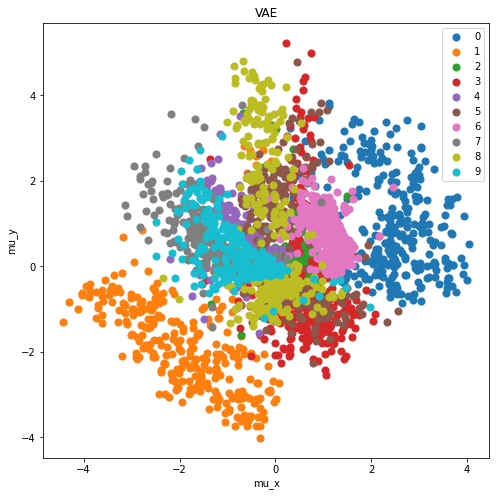

In [12]:
# plot the mu distribution for VAE
X, Y = mu_vae[:, 0], mu_vae[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
for i in np.arange(10):
    ix = np.where(labels == i)
    ax.scatter(X[ix], Y[ix], c='C'+str(i), label=i, s=50)
ax.legend()
plt.title('VAE')
plt.xlabel('mu_x')
plt.ylabel('mu_y')
plt.show()

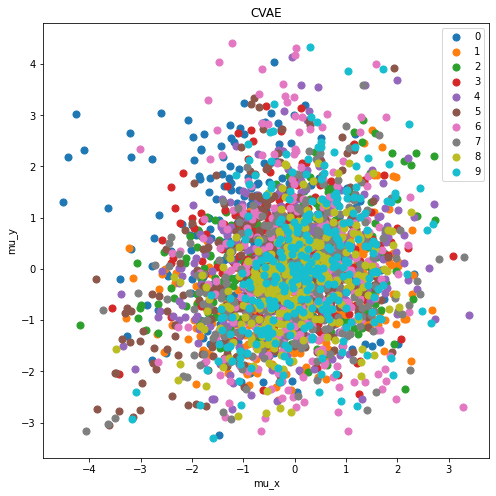

In [13]:
# plot the mu distribution for CVAE
X, Y = mu_cvae[:, 0], mu_cvae[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
for i in np.arange(10):
    ix = np.where(labels == i)
    ax.scatter(X[ix], Y[ix], c='C'+str(i), label=i, s=50)
ax.legend()
plt.title('CVAE')
plt.xlabel('mu_x')
plt.ylabel('mu_y')
plt.show()

### Task 2: Visualize the decoding part

In [14]:
with torch.no_grad():
    # since we have 
    z = torch.randn(64, latent_size).to(device)
    y = torch.randint(0, 10, size=(64,)).to(device)

    # vae
    vae_out = vae.decode(z).view(-1, 1, 28, 28)
    save_image(vae_out, 'vae-sample.png')

    # cvae, z without rescaling
    cvae_out_1 = cvae.decode(z, y).view(-1, 1, 28, 28)
    save_image(cvae_out_1, 'cvae-sample-1.png')

    # cvae, z rescaled by 0.1
    cvae_out_2 = cvae.decode(z*0.4, y).view(-1, 1, 28, 28)
    save_image(cvae_out_2, 'cvae-sample-2.png')

y = np.reshape(y.cpu().numpy(), (8,8))
print('Label information to guide CVAE:\n', np.matrix(y))

Label information to guide CVAE:
 [[4 8 3 7 4 6 7 6]
 [3 2 6 7 4 3 5 6]
 [7 2 3 6 7 7 2 7]
 [8 5 0 5 5 6 5 7]
 [0 0 8 8 2 2 2 9]
 [1 9 2 9 2 2 2 7]
 [8 4 2 8 1 7 2 7]
 [1 8 1 3 5 2 2 2]]


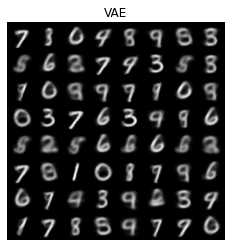

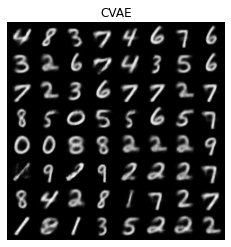

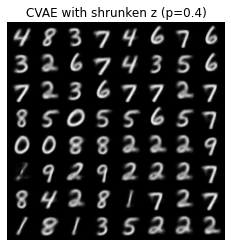

In [15]:
img = mpimg.imread('vae-sample.png')
plt.axis('off')
plt.imshow(img)
plt.title('VAE')
plt.show()

img = mpimg.imread('cvae-sample-1.png')
plt.axis('off')
plt.imshow(img)
plt.title('CVAE')
plt.show()

img = mpimg.imread('cvae-sample-2.png')
plt.axis('off')
plt.imshow(img)
plt.title('CVAE with shrunken z (p=0.4)')
plt.show()